# Generate pileup data for ATLAS using a GAN (Generative Adversarial Network)

In [4]:
#imports
import numpy as np
import sys
import pandas as pd
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.image import decode_jpeg
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
import os
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import matplotlib.gridspec as gridspec
from pyjet import cluster, DTYPE_PTEPM
from pyjet.testdata import get_event
from matplotlib.colors import LogNorm
from atlasgan import reco
from atlasgan import keras_gan as gan
from atlasgan import train, dcgan

## Only have to run these cell once, then just skip over it and load next cell every other time

In [5]:
# normalization_constant = 487

# #load in the data
# local_path = os.getcwd()
# file_path = "/towahid/mu20_normalized_train.npy"
# data_path = local_path + file_path
# data_norm = np.load(data_path)

# data_full = np.multiply(data_norm, normalization_constant)
# jets_full = reco.reconstruct_events(data_full)

# export_csv = jets_full.to_csv(r'/home/wyattblair/working_jets.csv', index = None, header = True)
# np.save("working_train", data_full)
# np.save("working_normalized_train", data_norm)

# --------------------------------------------------------

In [6]:
local_path = os.getcwd()
file_name1 = "/working_train.npy"
file_name2 = "/working_normalized_train.npy"
file_name3 = "/working_jets.csv"
data_path = local_path + file_name1
data_norm_path = local_path + file_name2
jets_path = local_path + file_name3

data_full = np.load(data_path)
data_norm = np.load(data_norm_path)
jets = pd.read_csv(jets_path)

## Let's plot some of the training data

In [7]:
#Wahid's draw_image function
def draw_image(x, vmin=None, vmax=None, xlabel='$\eta$', ylabel='$\phi$',
               draw_cbar=True, ax=None, figsize=(5,4), **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    cax = ax.imshow(x.T, extent=[-2.5, 2.5, -3.15, 3.15],
                    norm=LogNorm(vmin, vmax), aspect='auto',
                    origin='lower', **kwargs)
    if draw_cbar:
        cbar = plt.gcf().colorbar(cax, ax=ax)
        cbar.set_label('Energy')
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

### Plot Individual Events

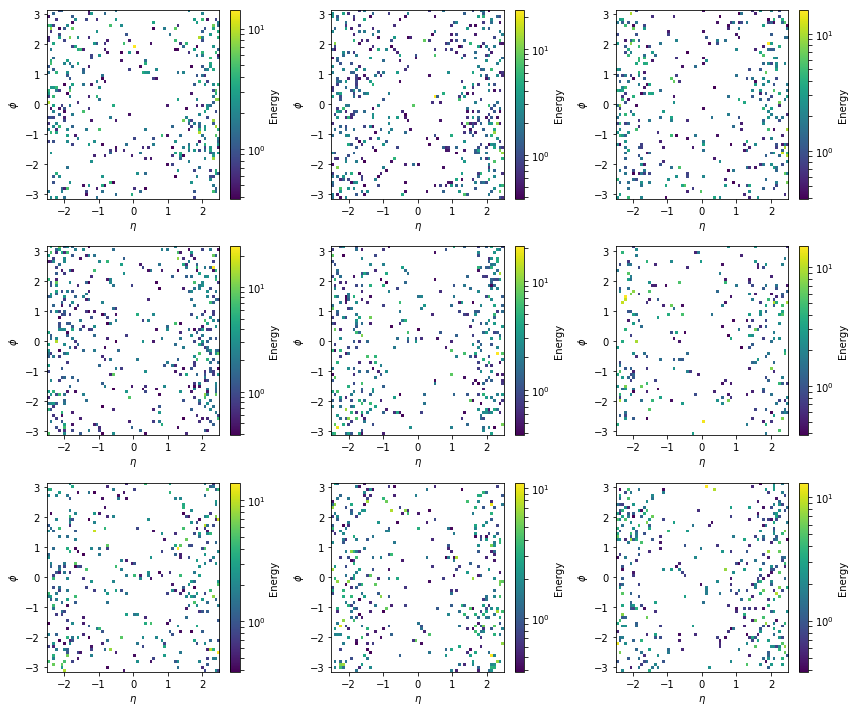

In [8]:
#Populate a list with 9 events from a chosen part of the data set (chosen via sample_seed)
sample_seed = 2
sample_events = []
for i in range(sample_seed, sample_seed+9):
    sample_events.append(data_full[i])

#Plot the events stored in sample_events using draw_image
fig, axs = plt.subplots(3,3, figsize=(12,10))
for i,ax in enumerate(axs.flatten()):
    draw_image(np.absolute(sample_events[i]), ax=ax)
plt.tight_layout()

### Plot the properties of the jets

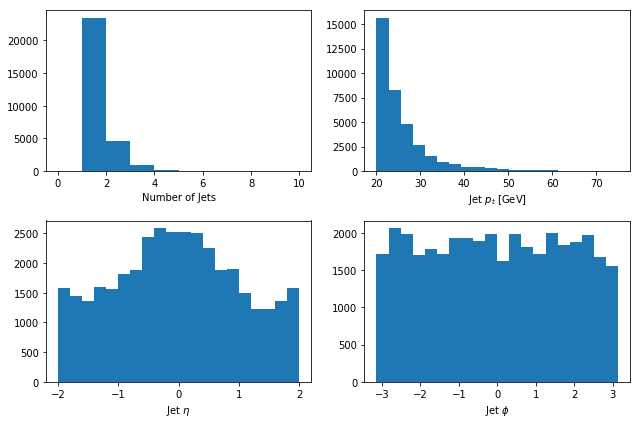

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(9,6))

#number of jets
jetCount = jets.groupby('event').size()
ax1.hist(jetCount, bins=10, range=(0,10))
ax1.set_xlabel('Number of Jets')

#jet pt
ax2.hist(jets.pt, bins=20, range=(20,75))
ax2.set_xlabel('Jet $p_t$ [GeV]')

#jet eta
ax3.hist(jets.eta, bins= 20, range=(-2,2))
ax3.set_xlabel('Jet $\eta$')

#jet phi
ax4.hist(jets.phi, bins= 20, range= (-np.pi, np.pi))
ax4.set_xlabel('Jet $\phi$')

plt.tight_layout()


<Figure size 432x288 with 0 Axes>

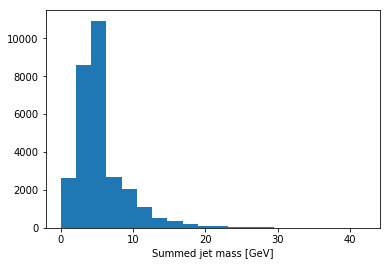

<Figure size 432x288 with 0 Axes>

In [10]:
# Sum of jet mass
sumMass = jets.groupby('event').apply(lambda x: x.m.sum())
plt.hist(sumMass, bins=20)
plt.xlabel('Summed jet mass [GeV]');

plt.figure()

## Let's start training the model

### Keras

In [38]:
Model = gan.GAN(data_norm)

BUILDING DISCRIMINATOR======>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        832       
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)

In [39]:
Model.train(epochs = 10)

0 [D loss: 3.016181, acc.: 35.55%] [G loss: 1.011412]
1 [D loss: 0.498697, acc.: 64.84%] [G loss: 5.217105]
2 [D loss: 0.028298, acc.: 100.00%] [G loss: 6.861020]
3 [D loss: 0.045017, acc.: 100.00%] [G loss: 4.927176]
4 [D loss: 0.248001, acc.: 91.02%] [G loss: 7.919332]
5 [D loss: 0.041461, acc.: 100.00%] [G loss: 8.782782]
6 [D loss: 0.043889, acc.: 100.00%] [G loss: 5.224602]
7 [D loss: 0.211665, acc.: 93.75%] [G loss: 8.768498]
8 [D loss: 0.031702, acc.: 99.61%] [G loss: 10.471330]
9 [D loss: 0.035463, acc.: 99.61%] [G loss: 6.908999]


In [26]:
noise = np.random.normal(0, 1, (1000, 1, Model.latent_dim))
gen_imgs_norm = Model.generator.predict(noise)

### Tensforflow

In [27]:
# Model = dcgan.dcgan()

In [28]:
# config:
# flags = tf.app.flags
# tf.app.flags.DEFINE_string('f', '', 'kernel')
# flags.DEFINE_string("dataset", "cosmo", "The name of dataset [cosmo]")
# flags.DEFINE_string("datafile", "data/cosmo_primary_64_1k_train.npy", "Input data file for cosmo")
# flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
# flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
# flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
# flags.DEFINE_float("flip_labels", 0, "Probability of flipping labels [0]")
# flags.DEFINE_integer("z_dim", 100, "Dimension of noise vector z [100]")
# flags.DEFINE_integer("nd_layers", 4, "Number of discriminator convolutional layers. [4]")
# flags.DEFINE_integer("ng_layers", 4, "Number of generator conv_T layers. [4]")
# flags.DEFINE_integer("gf_dim", 64, "Dimension of gen filters in last conv layer. [64]")
# flags.DEFINE_integer("df_dim", 64, "Dimension of discrim filters in first conv layer. [64]")
# flags.DEFINE_integer("batch_size", 64, "The size of batch images [64]")
# flags.DEFINE_integer("output_size", 64, "The size of the output images to produce [64]")
# flags.DEFINE_integer("c_dim", 1, "Dimension of image color. [1]")
# flags.DEFINE_string("data_format", "NHWC", "data format [NHWC]")
# flags.DEFINE_boolean("transpose_matmul_b", False, "Transpose matmul B matrix for performance [False]")
# flags.DEFINE_string("checkpoint_dir", "checkpoints", "Directory name to save the checkpoints [checkpoint]")
# flags.DEFINE_string("experiment", "run_0", "Tensorboard run directory name [run_0]")
# flags.DEFINE_boolean("save_every_step", False, "Save a checkpoint after every step [False]")
# flags.DEFINE_boolean("verbose", True, "print loss on every step [False]")
# config = flags.FLAGS

In [29]:
# train.train_dcgan(data, config)

# Normalize generated data:

In [30]:
normalization_constant = 487
gen_imgs_full = np.multiply(gen_imgs_norm, normalization_constant)
gen_jets = reco.reconstruct_events(gen_imgs_full)

#Save normalized data/jets for later

# np.save('working_gen_data.npy', gen_imgs)
# export_csv = gen_jets.to_csv(r'/home/wyattblair/working_gen_jets.csv', index = None, header = True) 

In [31]:
# Load saved data/jets if you want

# gen_imgs = np.load(local_path + '/working_gen_data.npy')
# gen_jets = pd.read_csv(local_path + '/working_gen_jets.csv')

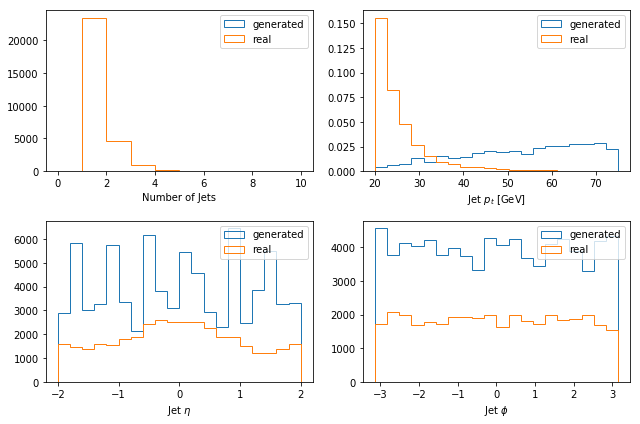

In [32]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(9,6))

#number of jets
gen_jetCount = gen_jets.groupby('event').size()
count, binning, patches = ax1.hist(gen_jetCount, label = "generated", bins=10, range=(0,10), histtype='step')
ax1.hist(jetCount, label = "real", bins=binning, histtype='step')
ax1.legend(loc=0)
ax1.set_xlabel('Number of Jets')

#jet pt
ax2.hist(gen_jets.pt, label="generated", bins=20, range=(20,75), normed = True, histtype='step')
ax2.hist(jets.pt, label="real", bins=20, range=(20,75), normed = True, histtype='step')
ax2.legend(loc=0)
ax2.set_xlabel('Jet $p_t$ [GeV]')

#jet eta
ax3.hist(gen_jets.eta, label="generated", bins= 20, range=(-2,2), histtype='step')
ax3.hist(jets.eta, label="real", bins=20, range=(-2,2), histtype='step')
ax3.legend(loc=0)
ax3.set_xlabel('Jet $\eta$')


#jet phi
ax4.hist(gen_jets.phi, label = "generated", bins= 20, range= (-np.pi, np.pi), histtype='step')
ax4.hist(jets.phi, label="real", bins=20, range= (-np.pi, np.pi), histtype='step')
ax4.legend(loc=0)
ax4.set_xlabel('Jet $\phi$')

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

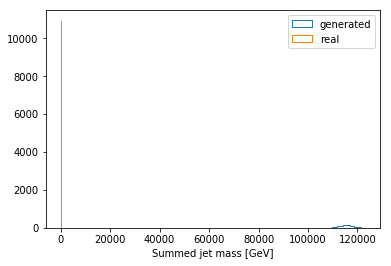

<Figure size 432x288 with 0 Axes>

In [33]:
# Sum of jet mass
gen_sumMass = gen_jets.groupby('event').apply(lambda x: x.m.sum())
plt.hist(gen_sumMass, label ="generated", bins=20, histtype='step')
plt.hist(sumMass, label="real",bins=20, histtype='step')
plt.xlabel('Summed jet mass [GeV]');
plt.legend(loc=0)

plt.figure()

In [34]:
#Stil TODO: Add the 2d convolutional layer in a manner that doesn't break the file

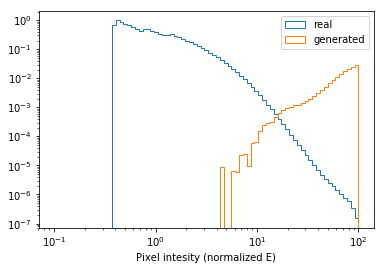

In [35]:
# Plot histogram of pixel intensities

plt.hist(data_full.flatten(),  bins=10**np.linspace(-1, 2, 80), normed=True,label='real', histtype='step')
plt.hist(gen_imgs_full.flatten(),  bins=10**np.linspace(-1, 2, 80), normed=True,label='generated', histtype='step')
plt.xlabel('Pixel intesity (normalized E)')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=0)

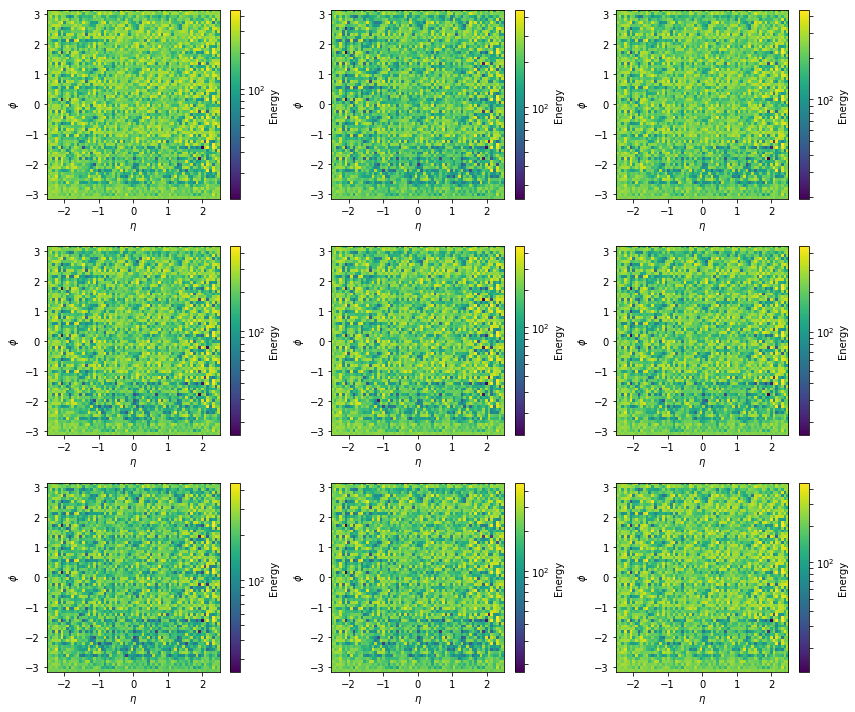

In [37]:
#Populate a list with 9 events from a chosen part of the data set (chosen via sample_seed)
gen_sample_seed = 0
gen_sample_events = []

for i in range(gen_sample_seed, gen_sample_seed+9):
    gen_sample_events.append(gen_imgs_full[i])


# #Plot the events stored in sample_events using draw_image
fig, axs = plt.subplots(3,3, figsize=(12,10))
for i,ax in enumerate(axs.flatten()):
    draw_image(np.absolute(gen_sample_events[i].squeeze()), ax=ax)
plt.tight_layout()

In [41]:
print("len(gen_jets): ", len(gen_jets))
print("sum(jetCount), sum(gen_jetCount), len(jetCount), len(gen_jetCount): ", sum(jetCount), sum(gen_jetCount), len(jetCount), len(gen_jetCount))
print("sum(gen_jets.eta): ", sum(gen_jets.eta))   


('len(gen_jets): ', 79359)
('sum(jetCount), sum(gen_jetCount), len(jetCount), len(gen_jetCount): ', 36761, 79359, 29329, 1000)
('sum(gen_jets.eta): ', -986.7847272804031)
